# Otoliths predictions

In [1]:
%matplotlib inline 
from util.useful_imports import *

## Exploratory analysis

** Load images from the root folder... **

In [2]:
loader = ImageFolder(root=TRAIN_DIR)
label_map = dict({loader.class_to_idx[name]: name for name in loader.classes})

There are 1342 images with 51 different labels:

Alver (1)
Ansjovis (9)
Baars (8)
Bittervoorn (2)
Blankvoorn (22)
Bot (30)
Braam (2)
Brakwatergrondel (42)
Brasem (6)
Dikkop (33)
Driedoornige stekelbaars (51)
Dunlipharder (2)
Dwergbolk (6)
Dwergtong (11)
Engelse poon (2)
Fint (28)
Gevlekte pitvis (6)
Gewone pitvis (35)
Gewone slakdolf (32)
Gewone tong (14)
Gewone zeedonderpad (5)
Glasgrondel (41)
Griet (2)
Haring (78)
Harnasmannetje (32)
Kabeljauw (10)
Kleine Pieterman (12)
Kleine zandspiering (214)
Kolblei (4)
Koornaarvis (4)
Lozano_s grondel (39)
Mul (8)
Pos (12)
Rasterpitvis (12)
Rode poon (19)
Sardien (13)
Schar (20)
Schelvis (4)
Schol (20)
Schurftvis (9)
Smelt (45)
Snoekbaars (13)
Snotolf (2)
Spiering (97)
Sprot (97)
Steenbolk (58)
Tiendoornige stekelbaars (19)
Tongschar (6)
Vijfdradige Meun (17)
Wijting (36)
Zeebaars (52)


[Text(0,0,'Alver'),
 Text(0,0,'Ansjovis'),
 Text(0,0,'Baars'),
 Text(0,0,'Bittervoorn'),
 Text(0,0,'Blankvoorn'),
 Text(0,0,'Bot'),
 Text(0,0,'Braam'),
 Text(0,0,'Brakwatergrondel'),
 Text(0,0,'Brasem'),
 Text(0,0,'Dikkop'),
 Text(0,0,'Driedoornige stekelbaars'),
 Text(0,0,'Dunlipharder'),
 Text(0,0,'Dwergbolk'),
 Text(0,0,'Dwergtong'),
 Text(0,0,'Engelse poon'),
 Text(0,0,'Fint'),
 Text(0,0,'Gevlekte pitvis'),
 Text(0,0,'Gewone pitvis'),
 Text(0,0,'Gewone slakdolf'),
 Text(0,0,'Gewone tong'),
 Text(0,0,'Gewone zeedonderpad'),
 Text(0,0,'Glasgrondel'),
 Text(0,0,'Griet'),
 Text(0,0,'Haring'),
 Text(0,0,'Harnasmannetje'),
 Text(0,0,'Kabeljauw'),
 Text(0,0,'Kleine Pieterman'),
 Text(0,0,'Kleine zandspiering'),
 Text(0,0,'Kolblei'),
 Text(0,0,'Koornaarvis'),
 Text(0,0,'Lozano_s grondel'),
 Text(0,0,'Mul'),
 Text(0,0,'Pos'),
 Text(0,0,'Rasterpitvis'),
 Text(0,0,'Rode poon'),
 Text(0,0,'Sardien'),
 Text(0,0,'Schar'),
 Text(0,0,'Schelvis'),
 Text(0,0,'Schol'),
 Text(0,0,'Schurftvis'),
 Text(

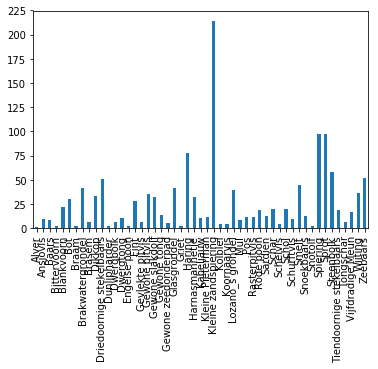

In [4]:
# print statitics
print('There are {} images with {} different labels:\n'.format(len(loader), len(loader.classes)))
frequencies = []
for label in loader.classes:
    idx = loader.class_to_idx[label]
    cant = sum([1 for (_, it) in loader if it == idx])
    frequencies.append(cant)
    print('{} ({})'.format(label, cant))   

freq_series = pd.Series.from_array(frequencies)
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(loader.classes)    

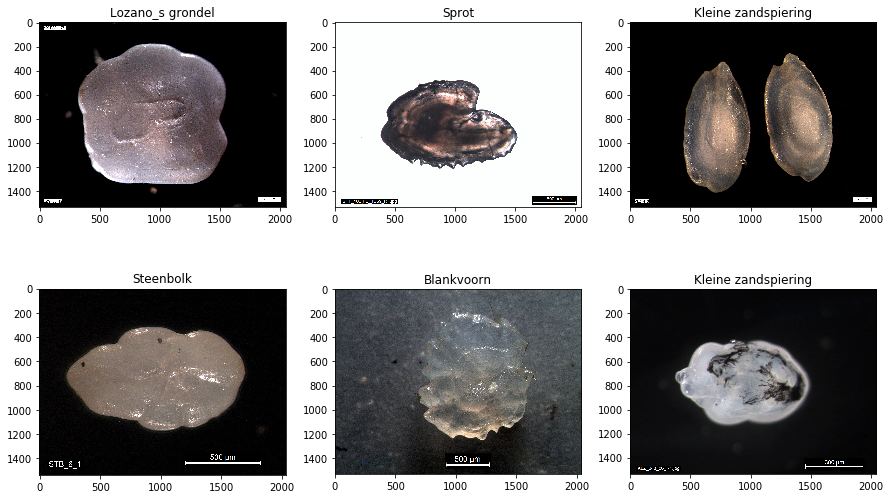

In [6]:
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

next_id = 0
for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(loader)-1)
        axs[i,j].imshow(loader[idx][0])
        axs[i,j].set_title(label_map[loader[idx][1]])
        next_id = next_id + 1

# Images
**Look closer to an individual image...**

One image has size of 2048x1536


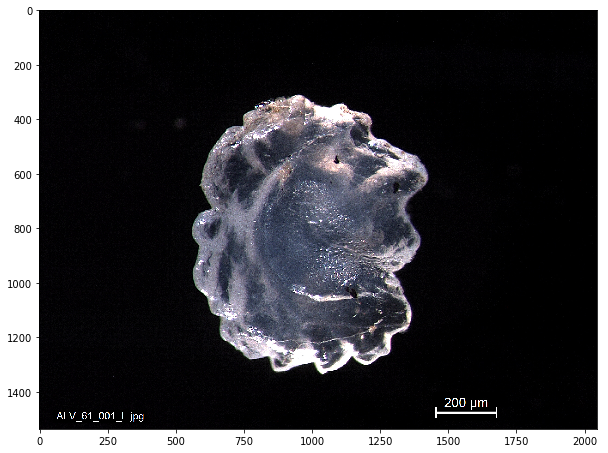

In [3]:
width, height = loader[1][0].size
print("One image has size of {}x{}".format(width, height))
plt.figure(figsize=(10,10))
plt.imshow(loader[0][0])

# Data processing

##  1. Partitioning data into training and test
### 1.1. Segment the training

In [ ]:
from skimage.io import imread, imsave

if os.path.exists(REF_SEG_DIR):
    shutil.rmtree(REF_SEG_DIR)
    
os.makedirs(REF_SEG_DIR)

threshold = 0.25
remove_bg = True
conv_sigma = 2.0
opening_size = 30

for label in os.listdir(ROOT_DIR):
    
    cur_dir = os.path.join(ROOT_DIR, label)
    tar_dir = os.path.join(REF_SEG_DIR, label)
    
    if not os.path.exists(tar_dir):
        os.makedirs(tar_dir)
    
    img_list = glob.glob(cur_dir + '/*.jpg')
    
    print(label)
    
    for image_path in img_list:
        
        image = imread(image_path)
        images_names = os.path.basename(image_path)
        images_names = images_names[0:-4] + '_{}.jpg'
        regions = ut.segment_image(image, remove_bg, threshold, conv_sigma,
                        opening_size)
        for i, reg in enumerate(regions):
            
            if len(images_names):
                min_row, min_col, max_row, max_col = reg.bbox
                segm_im = image[min_row:max_row][:,min_col:max_col]                             
                
                if segm_im.size / 8192 < 20.0: #this are noise
                    continue                    
                if segm_im.shape[0] == 1536 and segm_im.shape[1] == 2048: # cannot segment
                    continue 
                imsave(os.path.join(tar_dir, images_names.format(i+1)), segm_im)

Partition the data to train and valid

In [5]:
# create train and valid directories
if os.path.exists(TRAIN_DIR):
    shutil.rmtree(TRAIN_DIR)

os.makedirs(TRAIN_DIR)
    
if os.path.exists(VALID_DIR):
    shutil.rmtree(VALID_DIR)
    
os.makedirs(VALID_DIR)

train_per = 0.9

# making a partition of training and valid sets
for dire in os.listdir(REF_SEG_DIR):
    
    #create path for train
    p1 = os.path.join(TRAIN_DIR, dire)
    if not os.path.exists(p1):
        os.makedirs(p1)
        
    #create path for valid
    p2 = os.path.join(VALID_DIR, dire)
    if not os.path.exists(p2):
        os.makedirs(p2)
    
    img_list = glob.glob(os.path.join(REF_SEG_DIR, dire) + '/*.jpg')
    n = len(img_list)
    rp = np.random.permutation(n)

    # number of training images
    train = math.floor(train_per * n)
    
    for i in range(n):
        j = rp[i]
        
        filepath = img_list[j]
        filename = os.path.basename(filepath)
        
        if i < train or n <= 5:
            copyfile(filepath, p1 + '/' + filename)
        
        if i >= train or n <= 5:
            copyfile(filepath, p2 + '/' + filename)

## 2. Create test data

Prepare a list of test images, containing all paths

In [3]:
img_list = []

for dire in os.listdir(SAMPLE_DIR):
    my_dir = os.path.join(SAMPLE_DIR, dire)
    for subdir in os.listdir(my_dir):        
        cur_dir = os.path.join(my_dir,subdir)
        if not os.path.isdir(cur_dir):
            continue
        #print(cur_dir)        
        jpg_list = glob.glob(cur_dir + '/*.jpg')
        tif_list = glob.glob(cur_dir + '/*.tif')
        
        img_list.extend(jpg_list)
        
        for tif_file in tif_list:
            name = os.path.basename(tif_file)
            name = name[0:-4]
            # check if format .jpg does not exist in the list
            if name + '.jpg' not in jpg_list:
                img_list.append(tif_file)

Segment all images

In [ ]:
from skimage.io import imread, imsave

if os.path.exists(TEST_DIR):
    shutil.rmtree(TEST_DIR)
    
os.makedirs(TEST_DIR)

threshold = 0.25
remove_bg = True
conv_sigma = 2.0
opening_size = 30

for image_path in img_list:

    image = imread(image_path)    
    images_names = os.path.basename(image_path)
    images_names = images_names[0:-4] + '_{}.jpg'

    regions = ut.segment_image(image, remove_bg, threshold, conv_sigma,
                        opening_size)

    for i, reg in enumerate(regions):
        if len(images_names):
            min_row, min_col, max_row, max_col = reg.bbox
            segm_im = image[min_row:max_row][:,min_col:max_col]            
            imsave(os.path.join(TEST_DIR, images_names.format(i+1)), segm_im)

## 3. Removing meta-info
** Data augmentation **
* Crop image
* Resize to 224 x 224
* Random Horizontal Flip
* Random Rotation (-45,+45)

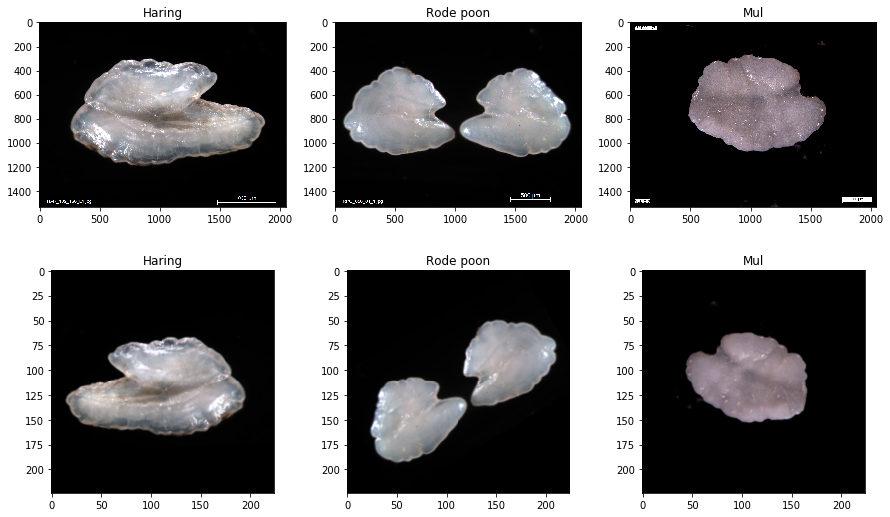

In [8]:
nrows, ncols = 2, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,9))

for j in range(ncols):
    idx = random.randint(0,len(loader)-1)
    axs[0,j].imshow(loader[idx][0])
    axs[0,j].set_title(label_map[loader[idx][1]])
    axs[1,j].imshow(data[idx][0])
    axs[1,j].set_title(label_map[data[idx][1]])

# Test performance

** Residual Networks for Image Recognition (reset18)**

** Train model **
* Loss function
$$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$
* Stochastic Gradient Descent with Momentum 0.9, weight decay 0.0001
* 50 epochs
* batch size 16
* valid error = 0.88

** Load model **

In [7]:
checkpoint = torch.load('output/best_resnet18.pth.tar', map_location=lambda storage, loc: storage)
model = models.resnet18()
model = CNNs.FineTuneModel(model, 'resnet18', len(loader.classes))
model.load_state_dict(checkpoint['state_dict'])

def predict_label(output):
    """ Compute the accuracy """
    _, pred = torch.max(output, 1)
    return label_map[pred.cpu().numpy().tolist()[0]]

** Predict **

** Correct predictions**

  9%|▉         | 5/53 [00:02<00:23,  2.03it/s]


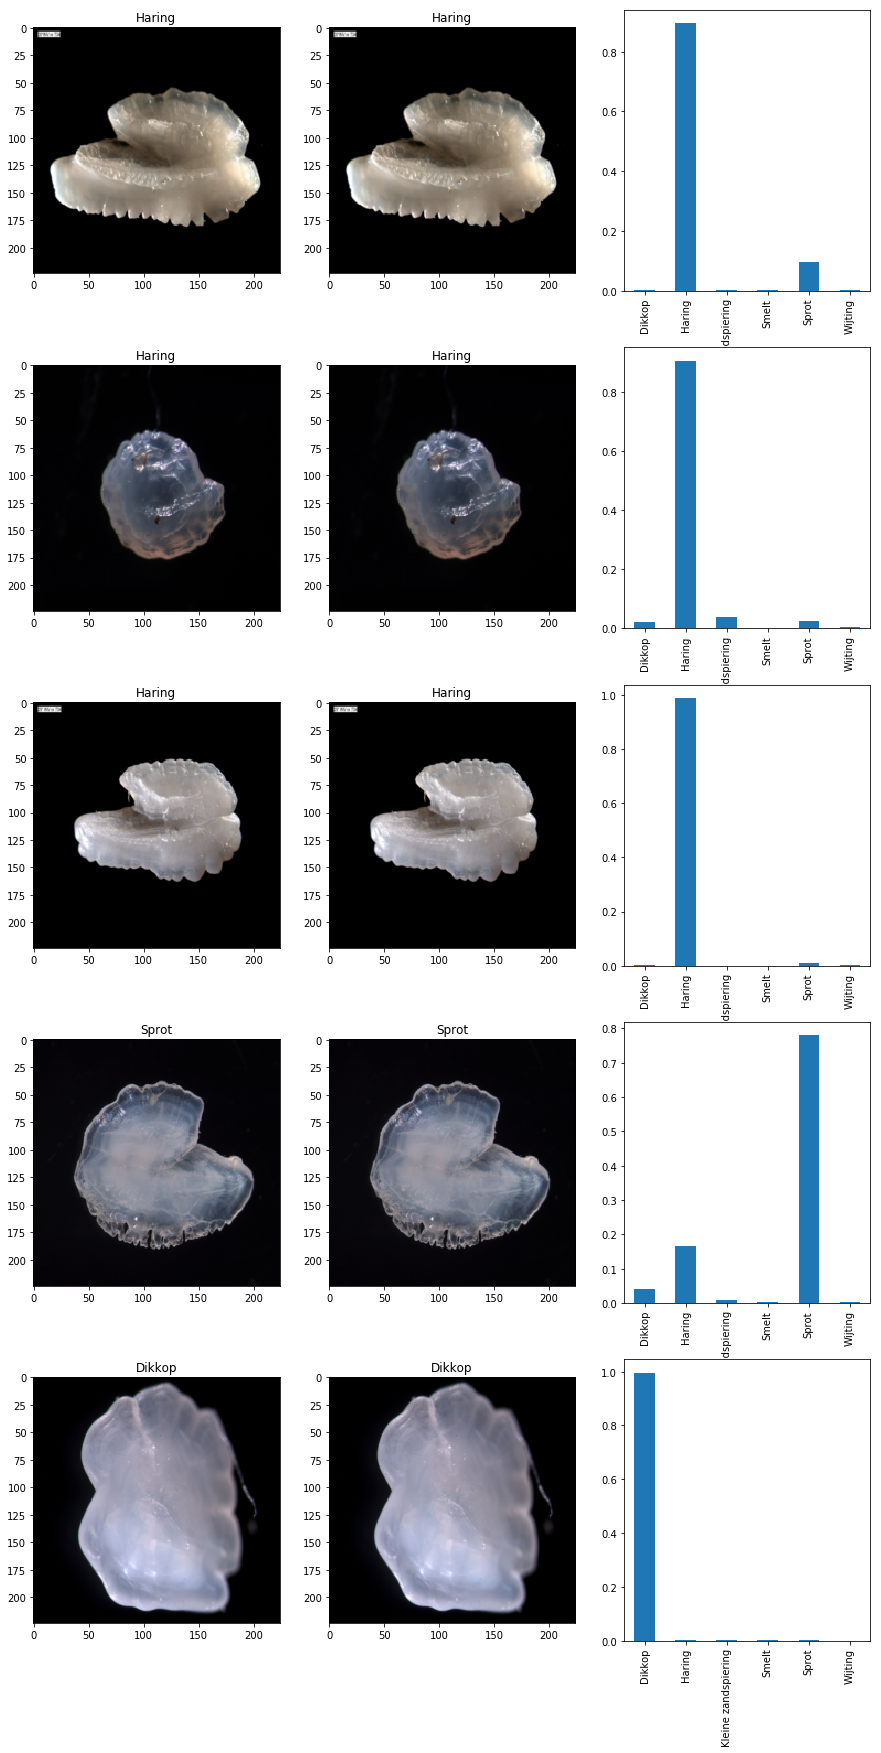

In [11]:
nrows, ncols = 5, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,30))

model.eval()
cnt = 0
sigmoid = nn.Softmax()
names = [label_map[i] for i in label_map.keys()]

for i in tqdm(range(len(dset_valid))):
    idx = random.randint(0,len(dset_valid)-1)
    img = dset_valid[idx][0]
    img = Variable(img[None, :])
    
    output = model(img)
    pred =  predict_label(output.data)       
    
    if (label_map[dset_valid[idx][1]] != pred):
        continue
    
    axs[cnt,0].imshow(dsetreal[idx][0])
    axs[cnt,0].set_title(label_map[dset_valid[idx][1]])
    
    axs[cnt,1].imshow(dsetreal[idx][0])
    axs[cnt,1].set_title(pred)
    
    #.
    pro = sigmoid(output).data.cpu().numpy()
    freq_series = pd.Series.from_array(pro[0,:])
    axs[cnt,2] = freq_series.plot(kind='bar', ax=axs[cnt,2])
    axs[cnt,2].set_xticklabels(names)
    
    
    cnt = cnt + 1
    if (cnt == nrows):
        break
    

** Incorrect predictions **

 98%|█████████▊| 52/53 [00:15<00:00,  3.63it/s]

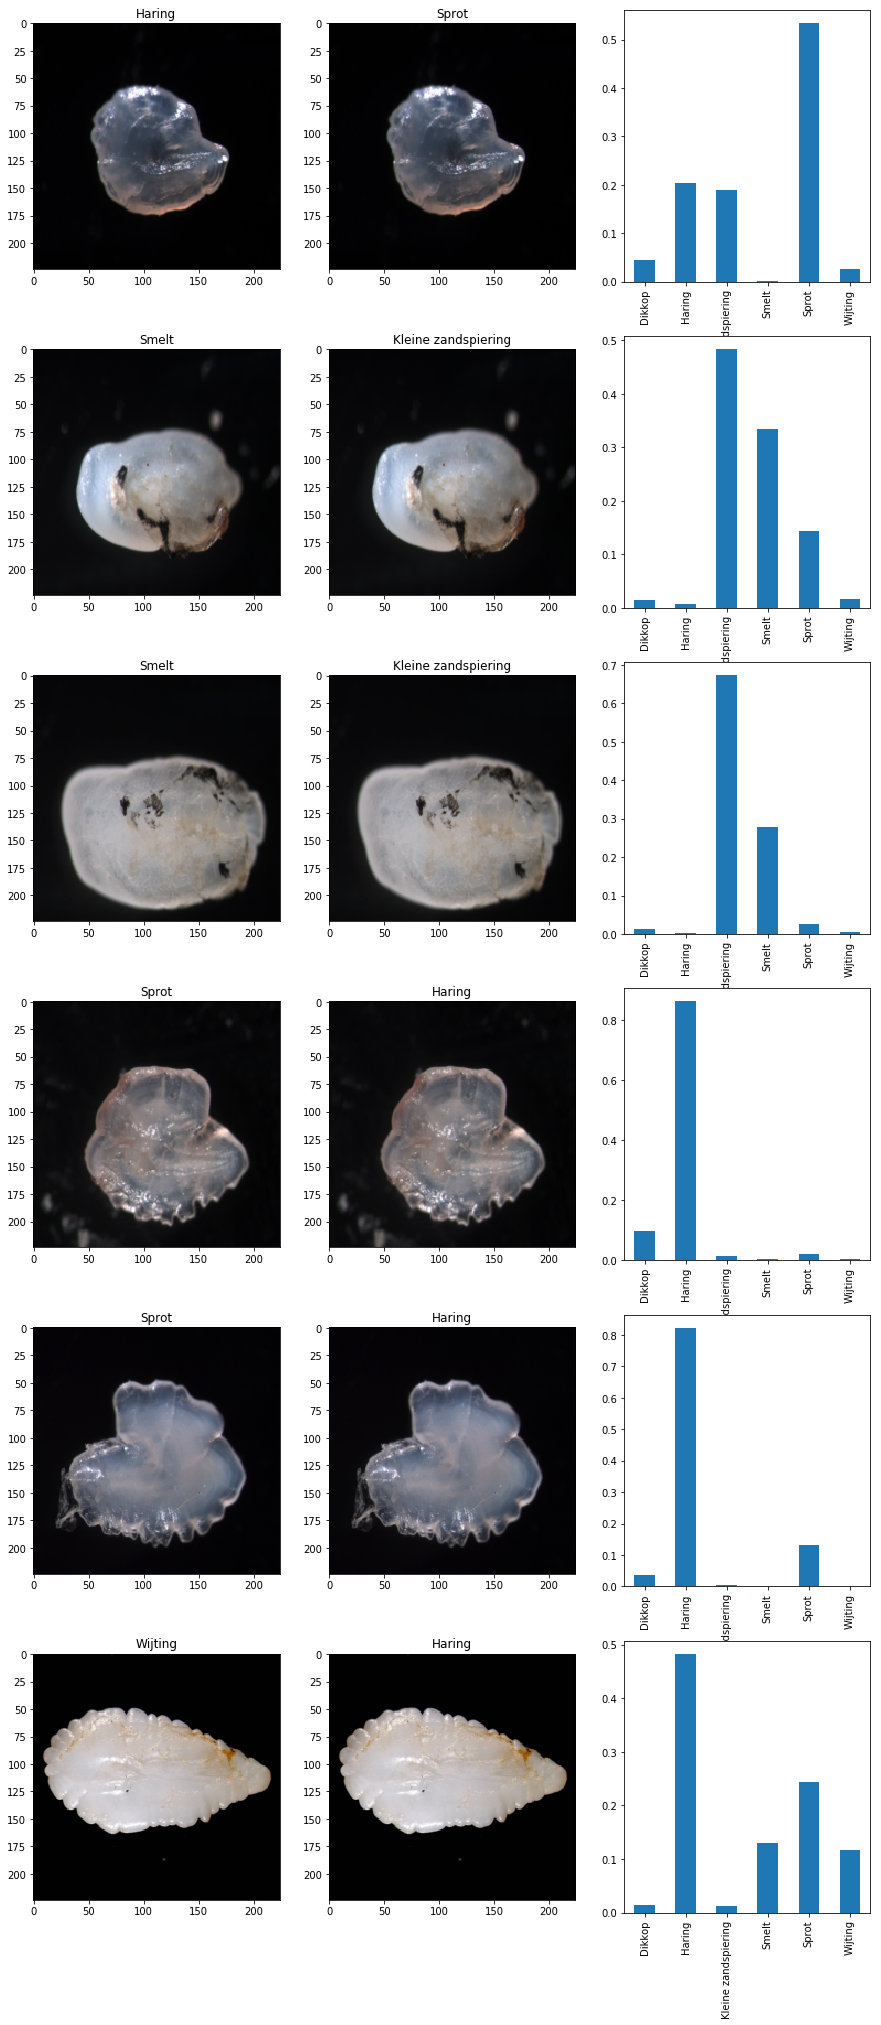

In [8]:
nrows, ncols = 6, 3
f, axs = plt.subplots(nrows, ncols, figsize=(15,35))

model.eval()
cnt = 0
sigmoid = nn.Softmax()
names = [label_map[i] for i in label_map.keys()]

for i in tqdm(range(len(dset_valid))):
    idx = i #random.randint(0,len(dset_valid)-1)
    img = dset_valid[idx][0]
    img = Variable(img[None, :])
    
    output = model(img)
    pred =  predict_label(output.data)       
    
    if (label_map[dset_valid[idx][1]] == pred):
        continue
    
    axs[cnt,0].imshow(dsetreal[idx][0])
    axs[cnt,0].set_title(label_map[dset_valid[idx][1]])
    
    axs[cnt,1].imshow(dsetreal[idx][0])
    axs[cnt,1].set_title(pred)
    
    #.
    pro = sigmoid(output).data.cpu().numpy()
    freq_series = pd.Series.from_array(pro[0,:])
    axs[cnt,2] = freq_series.plot(kind='bar', ax=axs[cnt,2])
    axs[cnt,2].set_xticklabels(names)
    
    
    cnt = cnt + 1
    if (cnt == nrows):
        break
    

# Problems
* **Mismatched training and test distributions ** (training images are high-resolution images)